In [41]:
!pip install wandb -qU

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/prcstak/HWTR%20v1/5ypx2rv1/file_stream
NoneType: None


In [42]:
import cv2
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Activation, MaxPooling2D, Dropout, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm import tqdm
from collections import Counter
from PIL import Image
from itertools import groupby

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
tf.__version__

'2.15.0'

In [43]:
import wandb
wandb.login()

True

In [44]:
dataset_path = '/kaggle/input/dataset1/train.tsv'
image_dir = '/kaggle/input/dataset1/test/'

dataset = pd.DataFrame(data=pd.read_csv(dataset_path, sep='\t', header=None)).dropna()

image_paths = dataset[0]
image_texts = dataset[1]

In [45]:
# alphabets = ' !"%\'()+,-./0123456789:;=?R[]bcehioprstuxy«»АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'
vocab = list(set("".join(map(str, image_texts))))
char_list = sorted(vocab)
print(char_list)

[' ', '!', '"', '%', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'R', '[', ']', 'b', 'c', 'e', 'h', 'i', 'o', 'p', 'r', 's', 't', 'u', 'x', 'y', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '№']


In [46]:
max_label_len = max([len(str(text)) for text in image_texts])
max_label_len

40

In [47]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, num_oov_indices=1, mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_list, mask_token=None, invert=True)

In [48]:
def encode_to_labels(txt):
    # encoding each output word into digits
#     return char_to_num(tf.strings.unicode_split(txt, input_encoding="UTF-8"))
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char)+1)
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=max_label_len, padding='post', value=len(char_list)+1)[0]
    

In [49]:
padded_image_texts = list(map(encode_to_labels, image_texts))

padded_image_texts[0]

array([ 57,  88,  85,  78,  88,  76,  74, 108, 108, 108, 108, 108, 108,
       108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
       108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108, 108,
       108], dtype=int32)

In [50]:
train_image_paths = image_paths[ : int(len(image_paths) * 0.90)]
train_image_texts = padded_image_texts[ : int(len(image_texts) * 0.90)]

val_image_paths = image_paths[int(len(image_paths) * 0.90) : ]
val_image_texts = padded_image_texts[int(len(image_texts) * 0.90) : ]

In [51]:
def process_single_sample(img_path, label):
    img = tf.io.read_file(image_dir+img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [32, 128])

    return {"image": img, "label": label}

In [52]:
run = wandb.init(
    project="HWTR v1",
    config={
        "epochs": 30,
        "batch_size": 256,
        "learning_rate": 0.01,
    }
)

config = run.config

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [53]:


train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths,
                                                    train_image_texts))

train_dataset = (
    train_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(config.batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_image_texts))
validation_dataset = (
    validation_dataset.map(
        process_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(config.batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

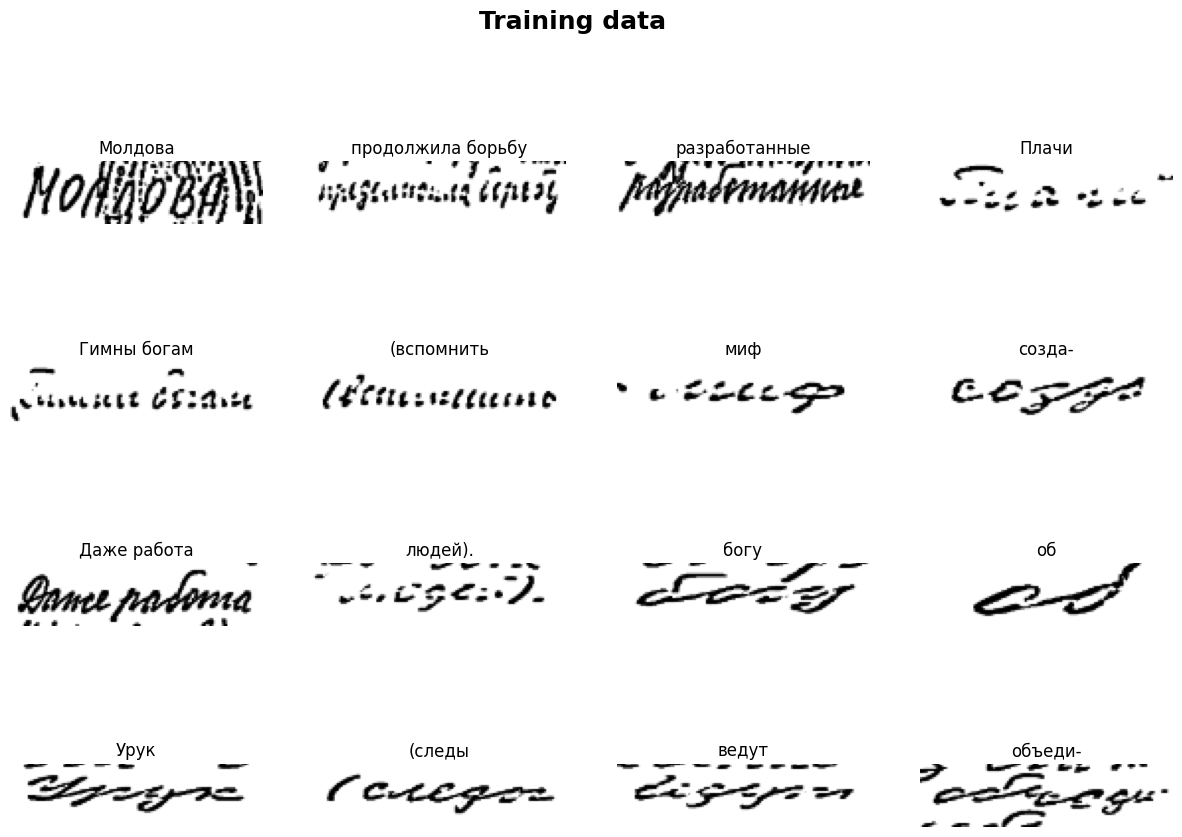

In [54]:
train_data_fig, ax = plt.subplots(4, 4, figsize=(15, 10))
train_data_fig.suptitle('Training data', weight='bold', size=18)


for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]

    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        label = label.replace('[UNK]', '')
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    
plt.show()

In [55]:


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length,
#             ignore_longer_outputs_than_inputs=True
        ),
        1,
    )

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [56]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p < len(char_list):
                ans += char_list[int(p)-1]
        
        text_list.append(ans)
        
    return text_list

In [57]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = validation_dataset.take(1)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)

#         orig_texts = []

#         for label in self.batch_labels:
#             orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :, 0] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()
        #plt.savefig("predictions_epoch_"+ str(epoch)+'.png', bbox_inches = 'tight', pad_inches = 0)
        
        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)


In [58]:
def train():
    
    # input with shape of height=32 and width=128 
    inputs = Input(name="image", shape=(32, 128, 1), dtype='float32')  # (None, 128, 64, 1)
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    # Convolution layer (VGG)
    inner = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(inputs)  # (None, 128, 64, 64)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)  # (None,64, 32, 64)

    inner = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)  # (None, 64, 32, 128)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)  # (None, 32, 16, 128)

    inner = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(inner)  # (None, 32, 16, 256)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 1), name='max3')(inner)  # (None, 32, 8, 256)

    inner = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512, (3, 3), padding='same', name='conv6')(inner)  # (None, 32, 8, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size=(2, 1), name='max4')(inner)  # (None, 32, 4, 512)

    inner = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(inner)  # (None, 32, 4, 512)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    # CNN to RNN
    inner = Reshape(target_shape=((64, 512)), name='reshape')(inner)  # (None, 32, 2048)
    inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)  # (None, 32, 64)

    # RNN layer
    lstm_1 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(inner)  # (None, 32, 512)
    lstm_1b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm1_b')(inner)
    reversed_lstm_1b = Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_1b)

    lstm1_merged = keras.layers.add([lstm_1, reversed_lstm_1b])  # (None, 32, 512)
    lstm1_merged = BatchNormalization()(lstm1_merged)

    lstm_2 = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='lstm2')(lstm1_merged)
    lstm_2b = LSTM(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='lstm2_b')(lstm1_merged)
    reversed_lstm_2b= Lambda(lambda inputTensor: K.reverse(inputTensor, axes=1)) (lstm_2b)

    lstm2_merged = keras.layers.concatenate([lstm_2, reversed_lstm_2b])  # (None, 32, 1024)
    lstm2_merged = BatchNormalization()(lstm2_merged)

    # transforms RNN output to character activations:
    inner = Dense(len(char_list) + 2, kernel_initializer='he_normal',name='dense2')(lstm2_merged) #(None, 32, 63)
    y_pred = Activation('softmax', name='dense')(inner)

    output = CTCLayer(name="ctc_loss")(labels, y_pred)

    optimizer = Adam(lr=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    #model to be used at training time
    model = Model(inputs=[inputs, labels], outputs=output)
    model.compile(optimizer = optimizer)

    print(model.summary())
    file_path = "C_LSTM_best.hdf5"
    
    checkpoint = WandbModelCheckpoint(filepath=file_path, 
                                monitor='val_loss', 
                                verbose=1, 
                                save_best_only=True, 
                                mode='min')

    callbacks_list = [checkpoint, 
                      WandbMetricsLogger(),
                      PlotPredictions(frequency=1),
                      EarlyStopping(patience=3, verbose=1)]
    with tf.device('/gpu:0'):
        history = model.fit(train_dataset, 
                            epochs = config.epochs,
                            validation_data=validation_dataset,
                            verbose = 1,
                            callbacks = callbacks_list,
                            shuffle=True)
    
    return model

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 128, 64)          640       ['image[0][0]']               
                                                                                                  
 batch_normalization_18 (Ba  (None, 32, 128, 64)          256       ['conv1[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 32, 128, 64)          0         ['batch_normalization_1

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


 98/255 [==========>...................] - ETA: 43s - loss: 42.2861

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


207/255 [=======================>......] - ETA: 13s - loss: 34.1527

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 32.8108
Epoch 1: val_loss improved from inf to 28.24381, saving model to C_LSTM_best.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 2s 13ms/step


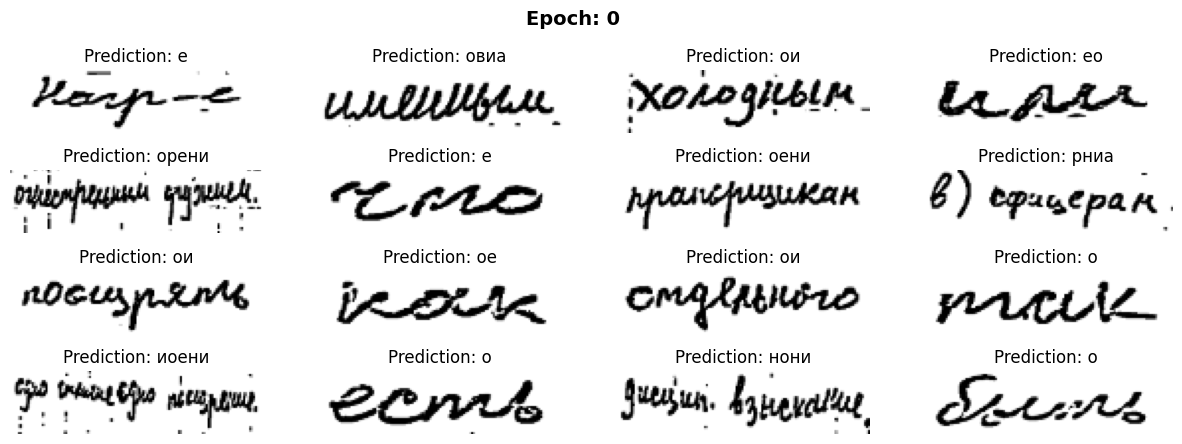

255/255 [==============================] - 98s 320ms/step - loss: 32.8108 - val_loss: 28.2438
Epoch 2/30
 19/255 [=>............................] - ETA: 1:04 - loss: 24.2118

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


128/255 [==============>...............] - ETA: 34s - loss: 24.4881

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


236/255 [==========================>...] - ETA: 5s - loss: 23.9932

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 23.9602
Epoch 2: val_loss improved from 28.24381 to 24.99146, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 2s 13ms/step


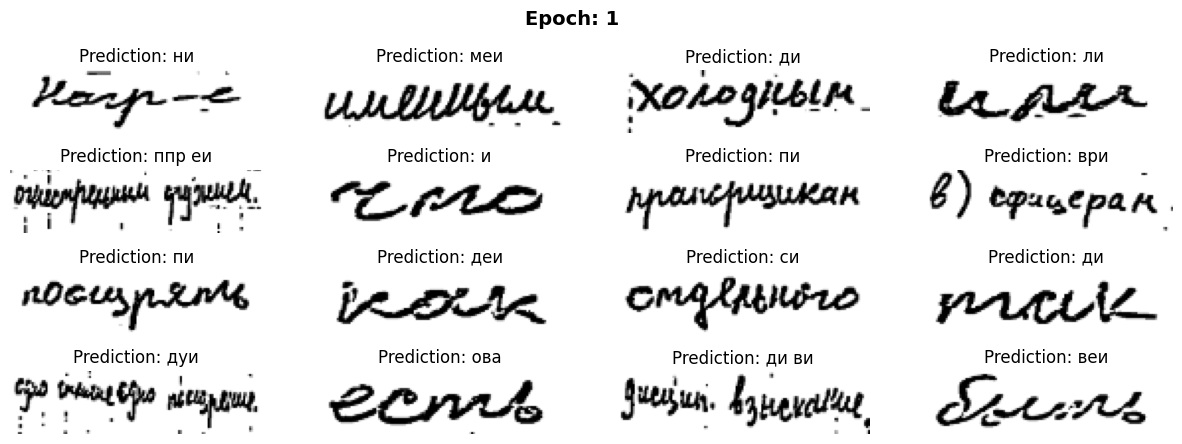

255/255 [==============================] - 78s 306ms/step - loss: 23.9602 - val_loss: 24.9915
Epoch 3/30
 62/255 [======>.......................] - ETA: 53s - loss: 19.9038

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


170/255 [===================>..........] - ETA: 23s - loss: 19.8749

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


254/255 [============================>.] - ETA: 0s - loss: 19.5203
Epoch 3: val_loss improved from 24.99146 to 22.14382, saving model to C_LSTM_best.hdf5


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


8/8 [==============================] - 1s 13ms/step


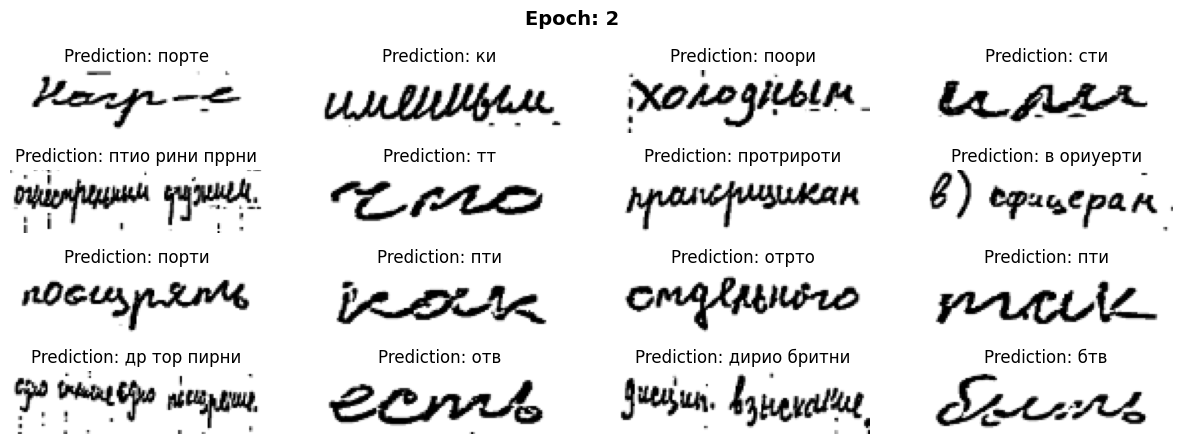

255/255 [==============================] - 78s 307ms/step - loss: 19.5197 - val_loss: 22.1438
Epoch 4/30
 91/255 [=========>....................] - ETA: 45s - loss: 16.7966

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


200/255 [======================>.......] - ETA: 15s - loss: 14.8188

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 15.1519
Epoch 4: val_loss improved from 22.14382 to 19.38593, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 2s 13ms/step


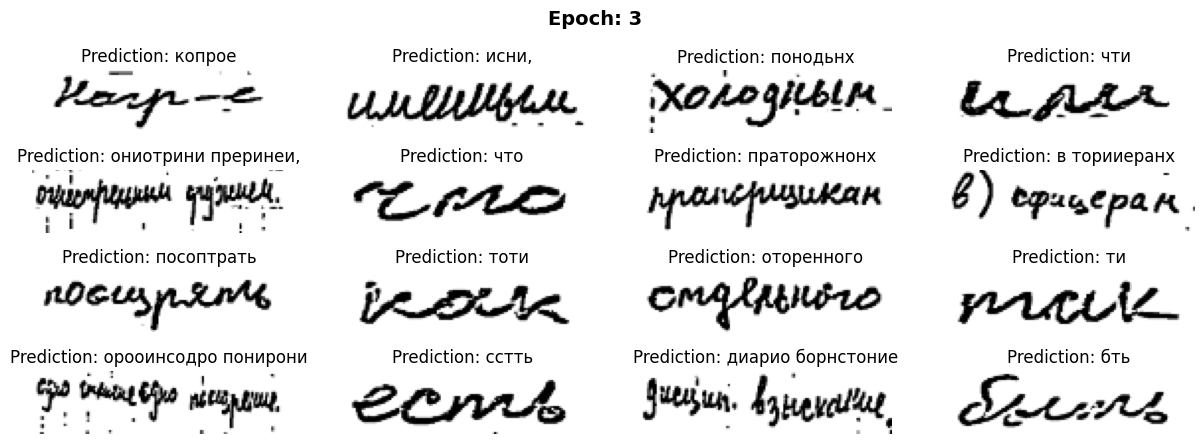

255/255 [==============================] - 79s 311ms/step - loss: 15.1519 - val_loss: 19.3859
Epoch 5/30
 21/255 [=>............................] - ETA: 1:03 - loss: 9.9883 

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


130/255 [==============>...............] - ETA: 34s - loss: 12.2510

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


240/255 [===========================>..] - ETA: 4s - loss: 11.5380

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 11.7058
Epoch 5: val_loss improved from 19.38593 to 18.11185, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 2s 13ms/step


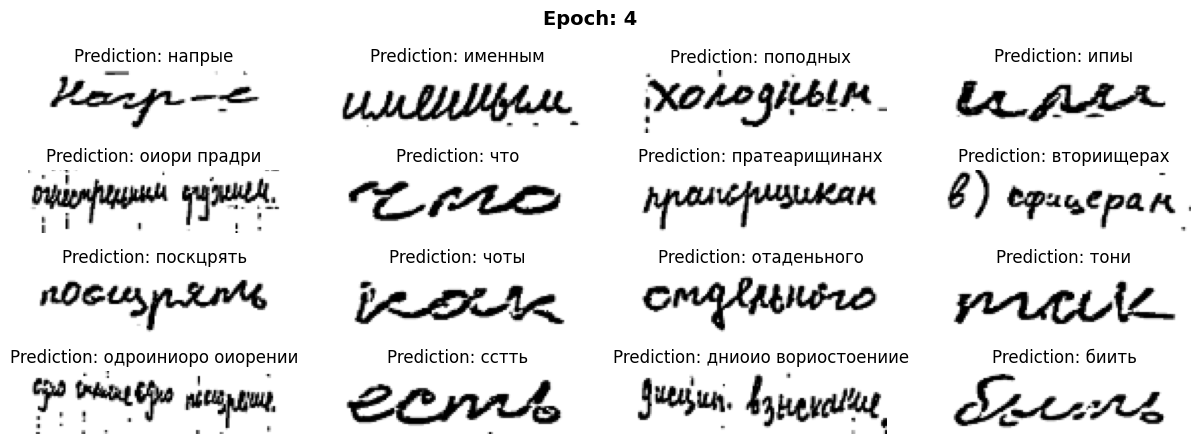

255/255 [==============================] - 78s 305ms/step - loss: 11.7058 - val_loss: 18.1118
Epoch 6/30
 65/255 [======>.......................] - ETA: 51s - loss: 9.6639

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


175/255 [===================>..........] - ETA: 21s - loss: 9.3303

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


254/255 [============================>.] - ETA: 0s - loss: 9.5636
Epoch 6: val_loss improved from 18.11185 to 16.25124, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 13ms/step


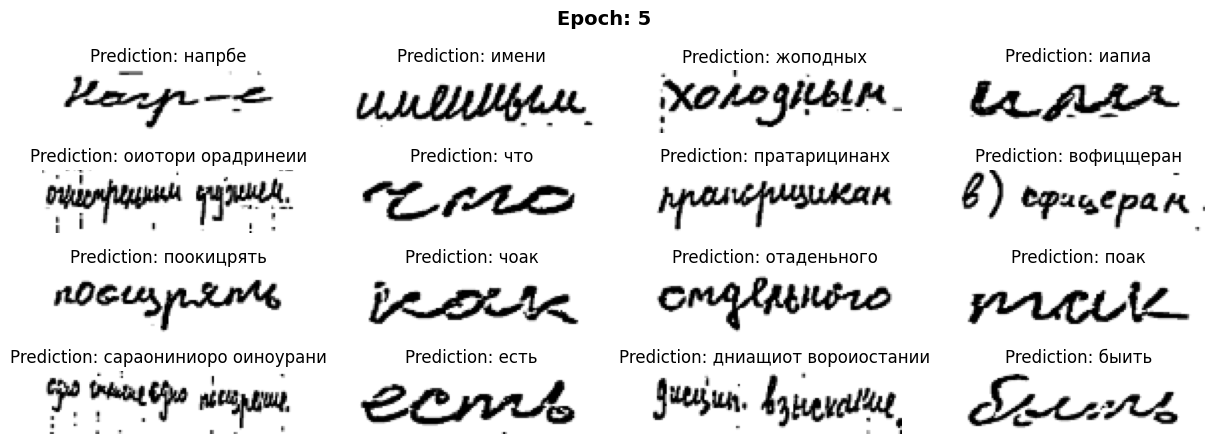

255/255 [==============================] - 77s 303ms/step - loss: 9.5629 - val_loss: 16.2512
Epoch 7/30
  1/255 [..............................] - ETA: 1:54 - loss: 10.4153

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


110/255 [===========>..................] - ETA: 39s - loss: 8.5129

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


219/255 [========================>.....] - ETA: 9s - loss: 7.6368 

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 8.0965
Epoch 7: val_loss did not improve from 16.25124
8/8 [==============================] - 1s 13ms/step


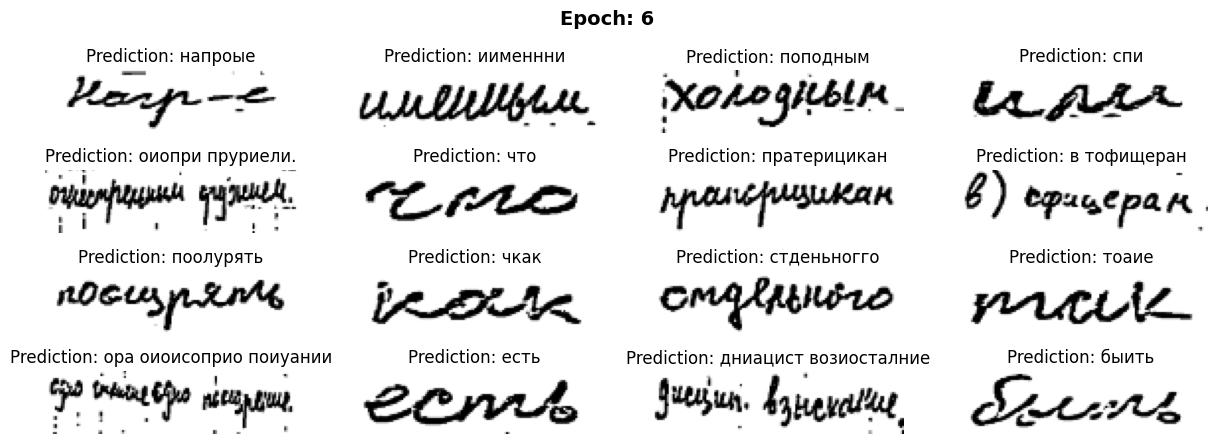

255/255 [==============================] - 78s 305ms/step - loss: 8.0965 - val_loss: 16.4266
Epoch 8/30
 57/255 [=====>........................] - ETA: 53s - loss: 6.3145

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


155/255 [=================>............] - ETA: 27s - loss: 6.6842

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 7.0157

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)



Epoch 8: val_loss improved from 16.25124 to 16.07184, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 2s 13ms/step


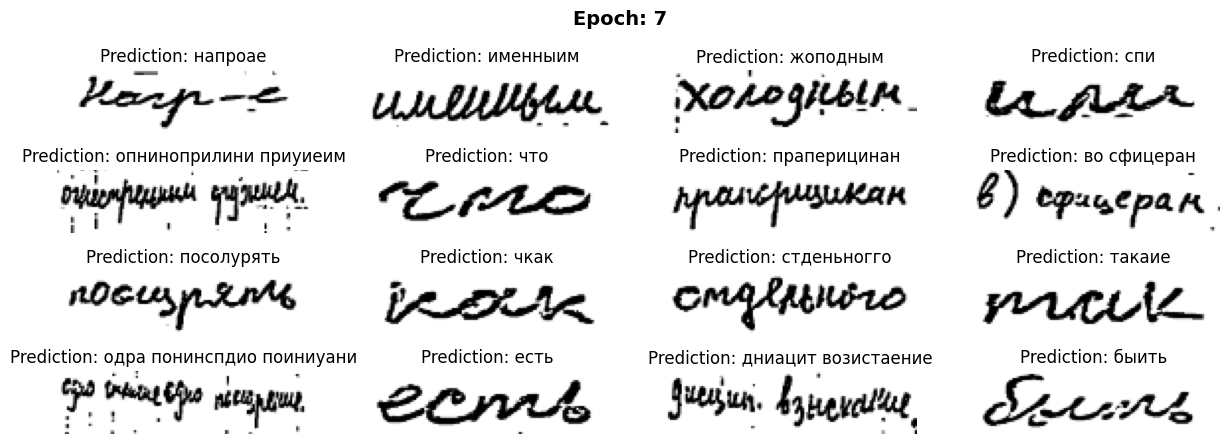

255/255 [==============================] - 77s 303ms/step - loss: 7.0157 - val_loss: 16.0718
Epoch 9/30
 92/255 [=========>....................] - ETA: 44s - loss: 6.4296

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


202/255 [======================>.......] - ETA: 14s - loss: 5.4980

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 6.1481
Epoch 9: val_loss did not improve from 16.07184
8/8 [==============================] - 1s 13ms/step


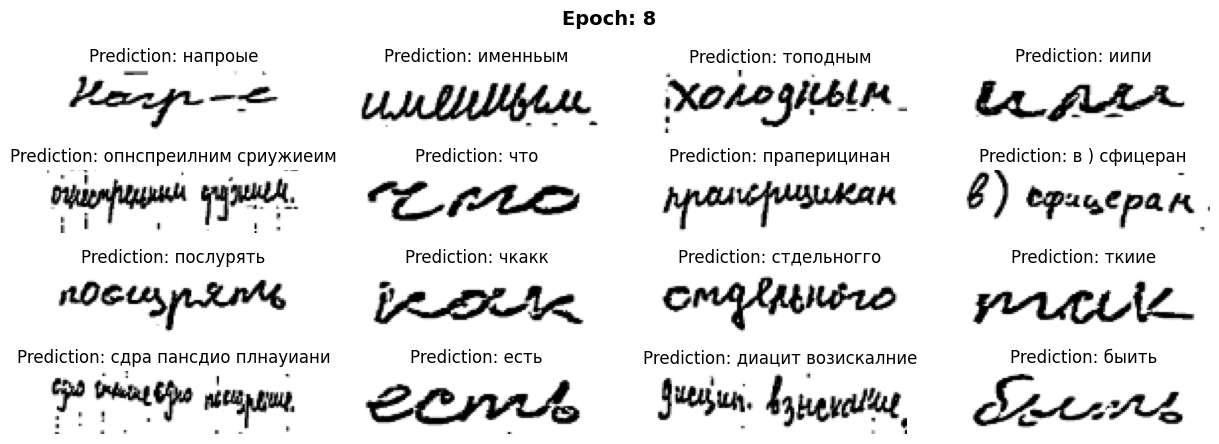

255/255 [==============================] - 77s 302ms/step - loss: 6.1481 - val_loss: 16.4296
Epoch 10/30
 29/255 [==>...........................] - ETA: 1:00 - loss: 3.7007

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


153/255 [=================>............] - ETA: 27s - loss: 5.0974

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


247/255 [============================>.] - ETA: 2s - loss: 5.3418

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 5.4703
Epoch 10: val_loss improved from 16.07184 to 15.24545, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 13ms/step


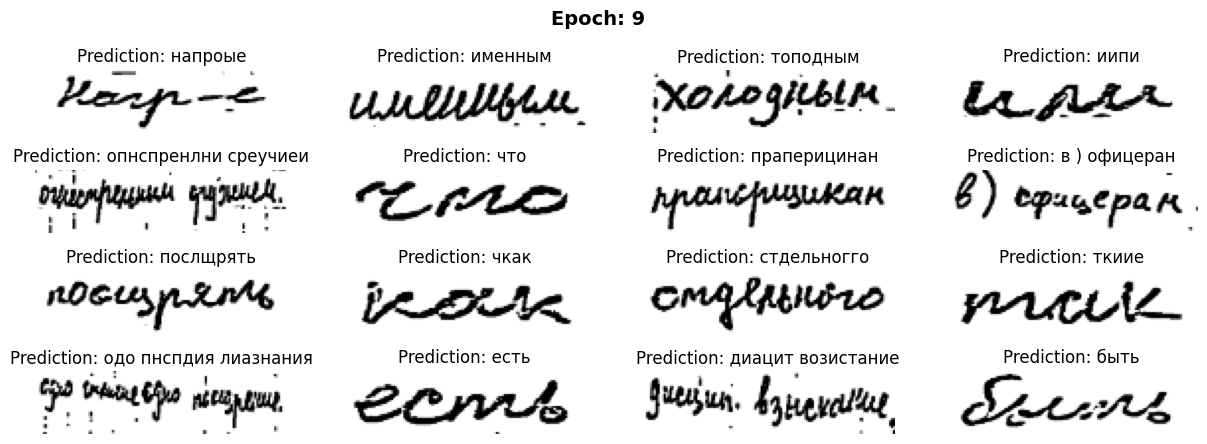

255/255 [==============================] - 79s 308ms/step - loss: 5.4703 - val_loss: 15.2454
Epoch 11/30
 70/255 [=======>......................] - ETA: 50s - loss: 4.6199

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


178/255 [===================>..........] - ETA: 21s - loss: 4.4925

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 4.9860
Epoch 11: val_loss improved from 15.24545 to 15.04822, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 2s 13ms/step


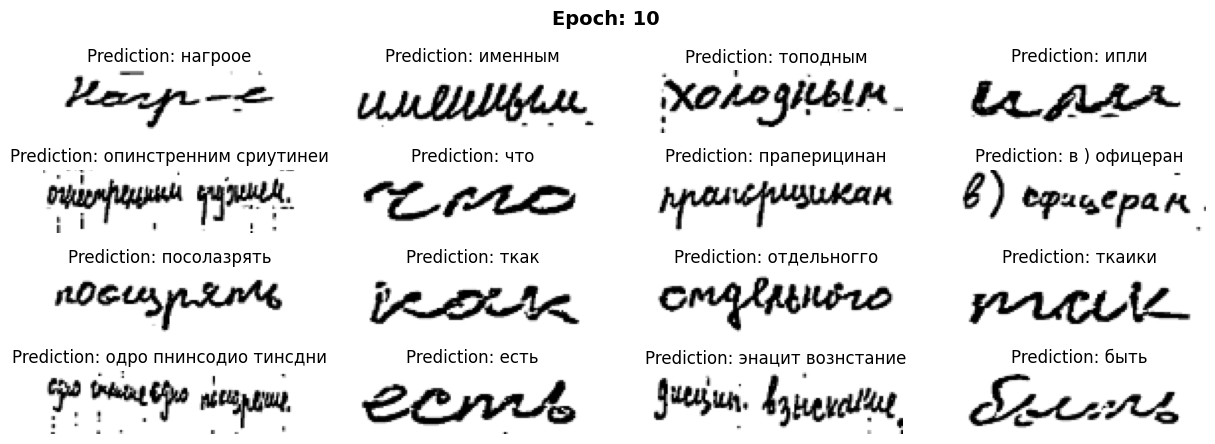

255/255 [==============================] - 78s 307ms/step - loss: 4.9860 - val_loss: 15.0482
Epoch 12/30
  3/255 [..............................] - ETA: 1:10 - loss: 5.4824

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


125/255 [=============>................] - ETA: 35s - loss: 4.4136

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


222/255 [=========================>....] - ETA: 9s - loss: 4.1129

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 4.5976
Epoch 12: val_loss did not improve from 15.04822
8/8 [==============================] - 1s 13ms/step


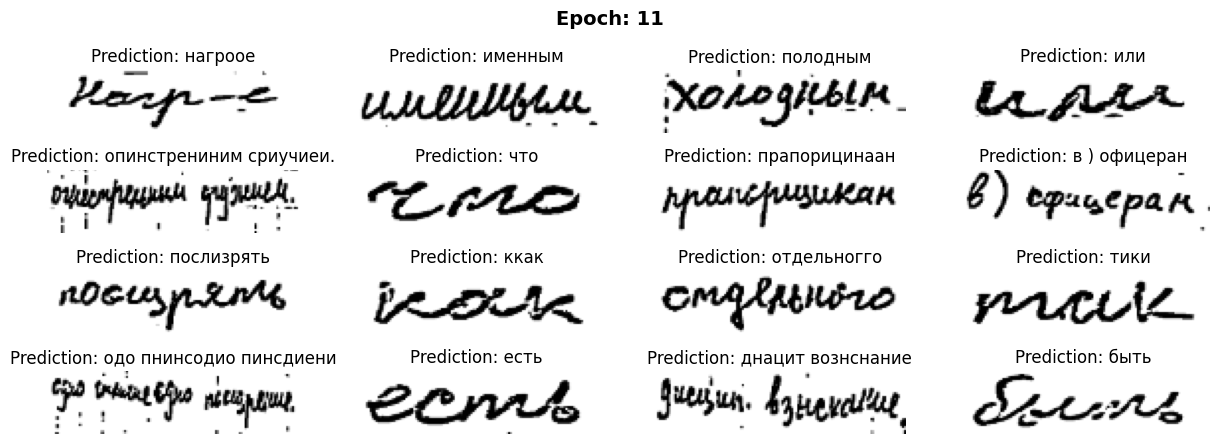

255/255 [==============================] - 77s 302ms/step - loss: 4.5976 - val_loss: 15.1003
Epoch 13/30
 49/255 [====>.........................] - ETA: 56s - loss: 3.5318

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


159/255 [=================>............] - ETA: 26s - loss: 3.8142

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 4.2168

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)



Epoch 13: val_loss improved from 15.04822 to 13.45029, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 2s 13ms/step


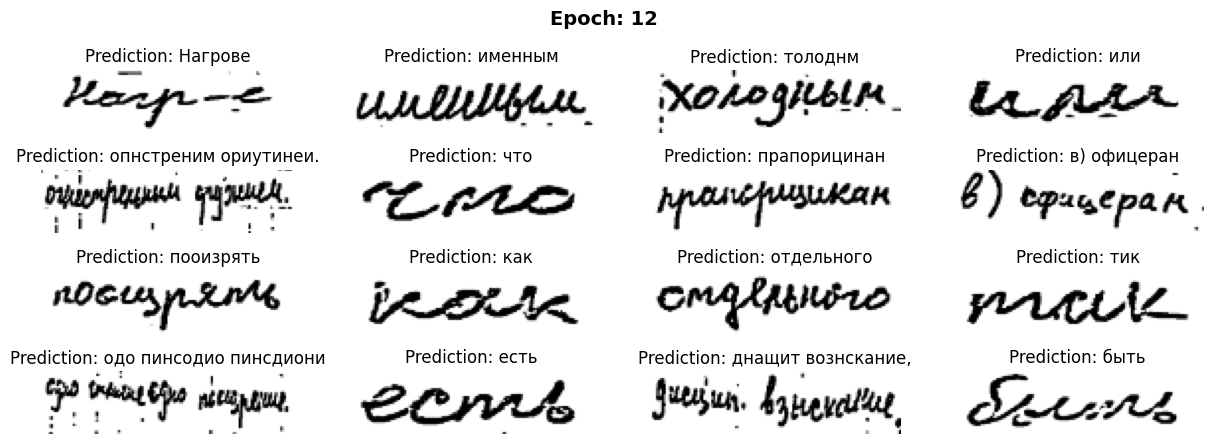

255/255 [==============================] - 78s 305ms/step - loss: 4.2168 - val_loss: 13.4503
Epoch 14/30
204/255 [=======================>......] - ETA: 13s - loss: 3.3249

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 3.8387
Epoch 14: val_loss improved from 13.45029 to 13.17048, saving model to C_LSTM_best.hdf5
8/8 [==============================] - 1s 13ms/step


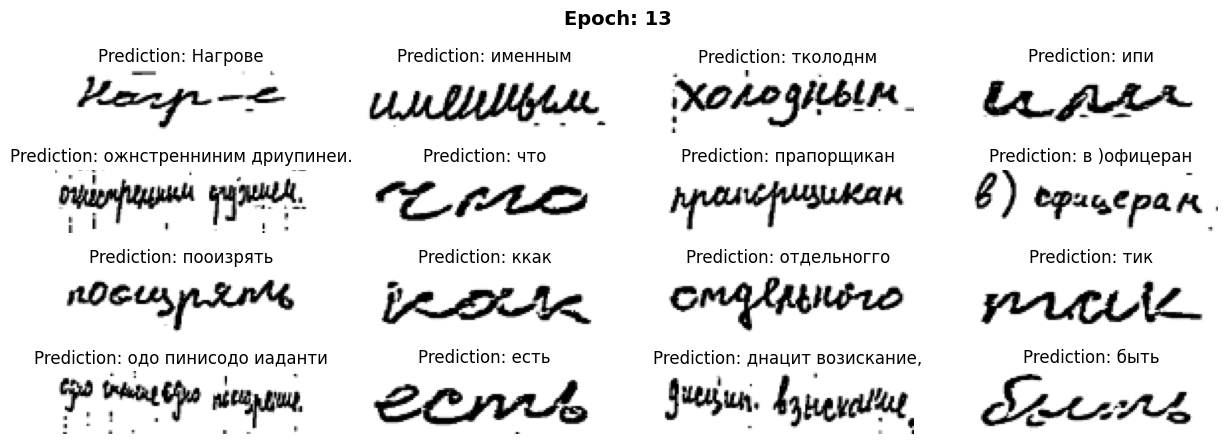

255/255 [==============================] - 77s 303ms/step - loss: 3.8387 - val_loss: 13.1705
Epoch 15/30
 30/255 [==>...........................] - ETA: 1:01 - loss: 2.2016

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


152/255 [================>.............] - ETA: 28s - loss: 3.1350

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


248/255 [============================>.] - ETA: 1s - loss: 3.3684

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


254/255 [============================>.] - ETA: 0s - loss: 3.4786
Epoch 15: val_loss did not improve from 13.17048
8/8 [==============================] - 2s 13ms/step


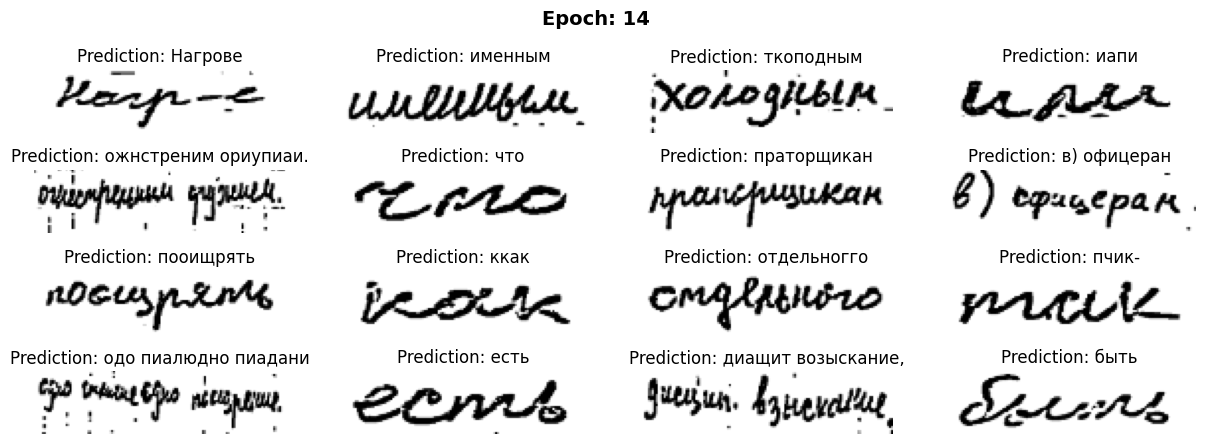

255/255 [==============================] - 78s 304ms/step - loss: 3.4773 - val_loss: 14.3977
Epoch 16/30
 76/255 [=======>......................] - ETA: 48s - loss: 2.8982

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


185/255 [====================>.........] - ETA: 19s - loss: 2.6629

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


254/255 [============================>.] - ETA: 0s - loss: 3.2001
Epoch 16: val_loss did not improve from 13.17048
8/8 [==============================] - 1s 13ms/step


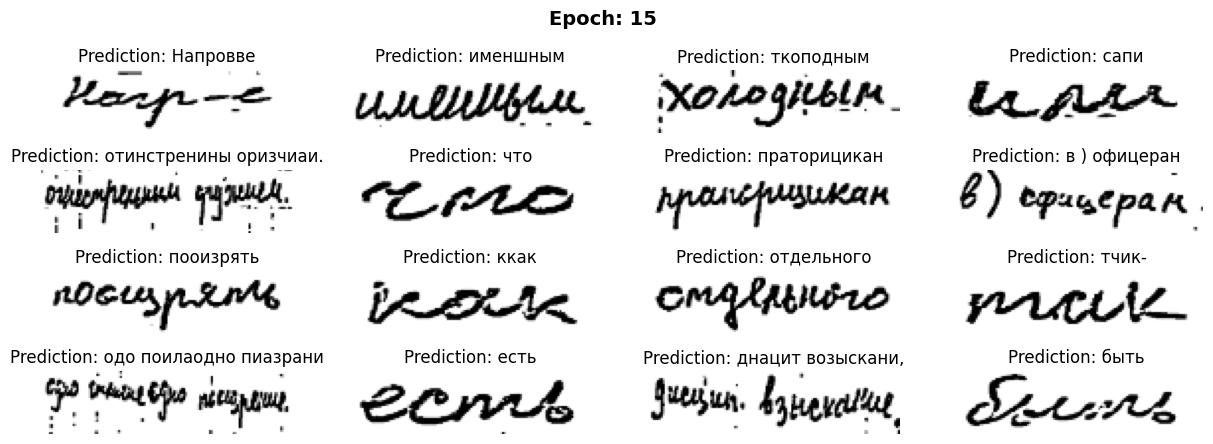

255/255 [==============================] - 77s 302ms/step - loss: 3.1988 - val_loss: 16.7436
Epoch 17/30
 13/255 [>.............................] - ETA: 1:05 - loss: 1.7898

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


122/255 [=============>................] - ETA: 36s - loss: 2.7173

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


231/255 [==========================>...] - ETA: 6s - loss: 2.5271

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


255/255 [==============================] - ETA: 0s - loss: 2.9598
Epoch 17: val_loss did not improve from 13.17048
8/8 [==============================] - 1s 13ms/step


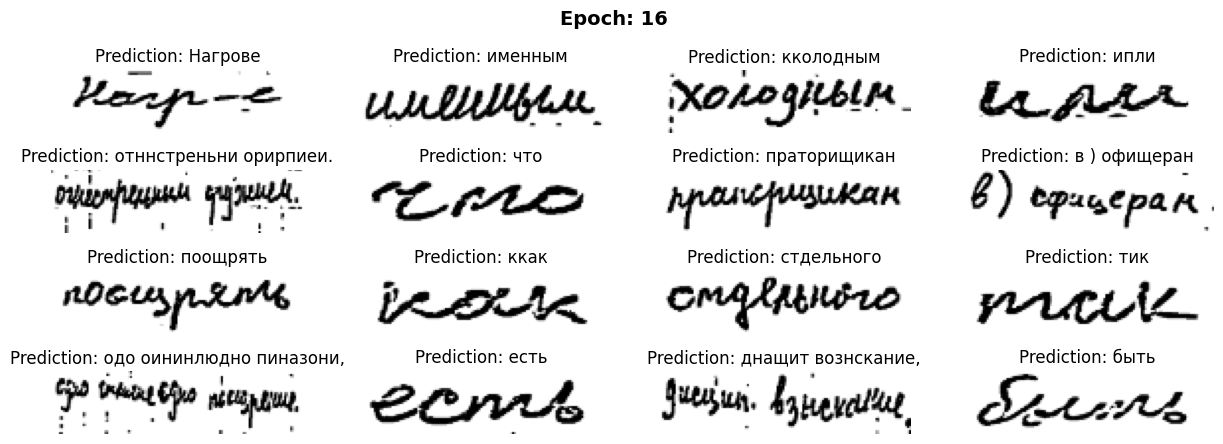

255/255 [==============================] - 78s 307ms/step - loss: 2.9598 - val_loss: 16.7585
Epoch 17: early stopping


In [59]:
model = train()

In [60]:
model.load_weights('C_LSTM_best.hdf5')

In [61]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense").output
)
prediction_model.summary()

Model: "model_44"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 32, 128, 64)          640       ['image[0][0]']               
                                                                                                  
 batch_normalization_18 (Ba  (None, 32, 128, 64)          256       ['conv1[0][0]']               
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 32, 128, 64)          0         ['batch_normalization_1

In [62]:
wandb.log({"prediction_for_each_epoch": [wandb.Image(fig, caption="epoch_"+str(i)) for i, fig in enumerate(figures_list)]})

8/8 [==============================] - 2s 14ms/step


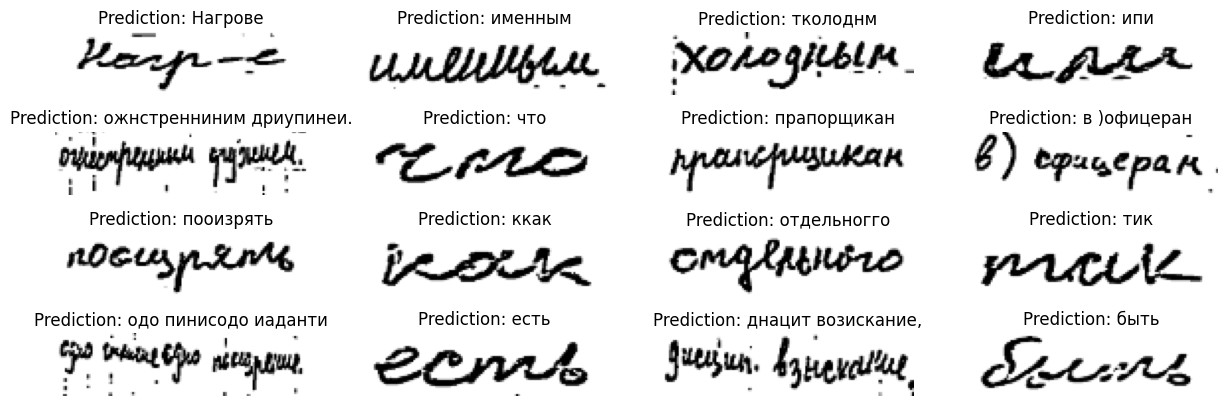

In [63]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):

    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = ctc_decoder(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig , ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):

        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
        
    wandb.log({"prediction_best_epoch": fig})
plt.show()


In [64]:
wandb.log({"prediction_best_epoch": fig})

In [65]:
run.finish()

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [66]:
## results can be improved with finetuning and including more data :)

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/prcstak/HWTR%20v1/5ypx2rv1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/prcstak/HWTR%20v1/5ypx2rv1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/prcstak/HWTR%20v1/5ypx2rv1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/prcstak/HWTR%20v1/5ypx2rv1/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/prcstak/HWTR%20v1/5ypx2rv1/fi